# Tri-Mouse Dataset Example with One-class Override
The Tri-Mouse dataset is related to Lauer et al. 2022 (Nature Methods) under CC BY-NC 4.0.

Train dataset: [https://zenodo.org/records/5851157](https://zenodo.org/records/5851157)

Test dataset: [https://zenodo.org/records/8437103](https://zenodo.org/records/8437103)

## Preparation
1. Download and extract the training dataset.

In [1]:
%%bash

# Define variables
TARGET_DIR="dataset/trimice-train/"
ZIP_FILE="trimice-train-dataset.zip"
URL="https://zenodo.org/records/5851157/files/trimice-dlc-2021-06-22.zip?download=1"

# Check if the directory exists
if [ ! -d "$TARGET_DIR" ]; then
    echo "$TARGET_DIR does not exist. Proceeding to download and extract..."

    # Download the file
    curl -o $ZIP_FILE "$URL"
    echo "Downloaded $ZIP_FILE."

    # Create parent directories
    mkdir -p "$TARGET_DIR"

    # Unzip the file
    unzip -q $ZIP_FILE -d $TARGET_DIR
    echo "Extracted files to $TARGET_DIR."

    # Remove the zip file
    rm $ZIP_FILE
    echo "Removed $ZIP_FILE."
else
    echo "$TARGET_DIR already exists. Skipping download and extraction."
fi

echo "Successfully downloaded train dataset."

dataset/trimice-train/ does not exist. Proceeding to download and extract...
Downloaded trimice-train-dataset.zip.
Extracted files to dataset/trimice-train/.
Removed trimice-train-dataset.zip.
Successfully downloaded train dataset.


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 23.3M  100 23.3M    0     0  6555k      0  0:00:03  0:00:03 --:--:-- 6556k


2. Similarly, download and extract test dataset.

In [2]:
%%bash

TARGET_DIR="dataset/trimice-test/"
ZIP_FILE="trimice-test-dataset.zip"
URL="https://zenodo.org/records/8437103/files/trimice-dlc-2021-06-22.zip?download=1"

if [ ! -d "$TARGET_DIR" ]; then
    echo "$TARGET_DIR does not exist. Proceeding to download and extract..."

    curl -o $ZIP_FILE "$URL"
    echo "Downloaded $ZIP_FILE."

    mkdir -p "$TARGET_DIR"

    unzip -q $ZIP_FILE -d $TARGET_DIR
    echo "Extracted files to $TARGET_DIR."

    rm $ZIP_FILE
    echo "Removed $ZIP_FILE."
else
    echo "$TARGET_DIR already exists. Skipping download and extraction."
fi

echo "Successfully downloaded test dataset."

dataset/trimice-test/ does not exist. Proceeding to download and extract...
Downloaded trimice-test-dataset.zip.
Extracted files to dataset/trimice-test/.
Removed trimice-test-dataset.zip.
Successfully downloaded test dataset.


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 11.0M  100 11.0M    0     0  4701k      0  0:00:02  0:00:02 --:--:-- 4702k


3. Download dependecies

In [3]:
%pip install --upgrade ultralytics deeplabcut2yolo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 896.3/896.3 kB 32.6 MB/s eta 0:00:00


## Convert DeepLabCut (DLC) to YOLO

1. Setup the arguments for d2y.

In [4]:
import deeplabcut2yolo as d2y
from pathlib import Path

dataset_path = Path("dataset/trimice-train/trimice-dlc-2021-06-22")  # Dataset directory to convert using d2y
# Note that the test dataset has no label and does not need to be converted

# List of directories (the image folders) for validation and training.
val_paths = list(dataset_path.glob("labeled-data/*short/"))
train_paths = [item for item in dataset_path.glob("labeled-data/*/") if item not in val_paths and item.suffix != ".cache"]  # Directories that don't contain the word "short"

# The skeleton from the trimouse dataset is ["snout", "leftear", "rightear", "shoulder", "spine1", "spine2", "spine3", "spine4", "tailbase", "tail1", "tail2", "tailend"].
# The only parts that are symmetric are the leftear (index 1) and the rightear (index 2)
skeleton_symmetric_pairs=[(1, 2)]

# Overriding classes
override_classes = [0, 0, 0]  # Or "000"
class_names = ["mouse"]

2. Run the conversion.

In [5]:
d2y.convert(
    dataset_path=dataset_path,
    train_paths=train_paths,
    val_paths=val_paths,
    skeleton_symmetric_pairs=skeleton_symmetric_pairs,
    data_yml_path="data.yml",
    override_classes=override_classes,
    class_names=class_names,
    verbose=True,
)

DeepLabCut2YOLO

Dataset path: dataset/trimice-train/trimice-dlc-2021-06-22
Found pickled labels: dataset/trimice-train/trimice-dlc-2021-06-22/training-datasets/iteration-0/UnaugmentedDataSet_trimiceJun22/trimice_dlc70shuffle1.pickle
Found config file: dataset/trimice-train/trimice-dlc-2021-06-22/config.yaml
  nc: 3
  names: {0: 'mus1', 1: 'mus2', 2: 'mus3'}
  kpt: ['snout', 'leftear', 'rightear', 'shoulder', 'spine1', 'spine2', 'spine3', 'spine4', 'tailbase', 'tail1', 'tail2', 'tailend']
  kpt_shape: [12, 3]
Overrided class indices with: (0, 0, 0)
Generating data.yml...
Created data.yml: data.yml
  path: /content
  train: ['dataset/trimice-train/trimice-dlc-2021-06-22/labeled-data/videocompressed0', 'dataset/trimice-train/trimice-dlc-2021-06-22/labeled-data/videocompressed20', 'dataset/trimice-train/trimice-dlc-2021-06-22/labeled-data/videocompressed4', 'dataset/trimice-train/trimice-dlc-2021-06-22/labeled-data/videocompressed1', 'dataset/trimice-train/trimice-dlc-2021-06-22/labeled-d

100%|██████████| 112/112 [00:00<00:00, 1209.52it/s]


Conversion completed!


## YOLO Transfer Learning

In [6]:
from ultralytics import YOLO

model = YOLO("yolov8n-pose.pt").load('yolov8n-pose.pt')
model.train(data="data.yml", epochs=20, imgsz=640)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.52M/6.52M [00:00<00:00, 80.5MB/s]


Transferred 397/397 items from pretrained weights
Ultralytics 8.3.38 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=pose, mode=train, model=yolov8n-pose.pt, data=data.yml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=yolov8n-pose.pt, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False

100%|██████████| 755k/755k [00:00<00:00, 20.2MB/s]


Overriding model.yaml kpt_shape=[17, 3] with kpt_shape=[12, 3]

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1 

100%|██████████| 5.35M/5.35M [00:00<00:00, 114MB/s]


AMP: checks passed ✅


train: Scanning /content/dataset/trimice-train/trimice-dlc-2021-06-22/labeled-data/videocompressed0... 62 images, 0 backgrounds, 0 corrupt: 100%|██████████| 62/62 [00:00<00:00, 710.76it/s]

train: New cache created: /content/dataset/trimice-train/trimice-dlc-2021-06-22/labeled-data/videocompressed0.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/dataset/trimice-train/trimice-dlc-2021-06-22/labeled-data/videocompressed06short... 50 images, 0 backgrounds, 0 corrupt: 100%|██████████| 50/50 [00:00<00:00, 854.88it/s]

val: New cache created: /content/dataset/trimice-train/trimice-dlc-2021-06-22/labeled-data/videocompressed06short.cache


Plotting labels to runs/pose/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 63 weight(decay=0.0), 73 weight(decay=0.0005), 72 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/pose/train
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.33G      3.244      10.61     0.7373      2.948      2.862         75        640: 100%|██████████| 4/4 [00:05<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.53s/it]

                   all         50        150     0.0678       0.44      0.072      0.021          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.25G      3.289      10.75      0.743      3.005      2.914         81        640: 100%|██████████| 4/4 [00:01<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.58it/s]

                   all         50        150     0.0769      0.453      0.074     0.0212          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.34G      2.681      10.66     0.7299      2.362      2.262         76        640: 100%|██████████| 4/4 [00:01<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.38it/s]

                   all         50        150      0.456      0.573      0.443      0.208          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.26G      1.804      10.44     0.7083      1.667      1.535         75        640: 100%|██████████| 4/4 [00:01<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.41it/s]

                   all         50        150      0.462        0.5      0.533      0.277          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.27G      1.663      10.15     0.6936      1.419      1.389         79        640: 100%|██████████| 4/4 [00:00<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.54it/s]

                   all         50        150      0.735       0.64      0.691      0.368          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.28G      1.586       10.1     0.6885      1.327      1.337         91        640: 100%|██████████| 4/4 [00:00<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.13it/s]

                   all         50        150      0.857      0.718      0.808      0.437          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.27G      1.491      9.736      0.679      1.198      1.272         96        640: 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.11it/s]

                   all         50        150      0.797      0.747      0.859      0.504          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.27G      1.349      9.593     0.6716      1.088      1.184         78        640: 100%|██████████| 4/4 [00:01<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.69it/s]

                   all         50        150       0.74      0.912      0.911       0.55          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.28G      1.441      9.494     0.6648      1.104      1.231         92        640: 100%|██████████| 4/4 [00:00<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.82it/s]

                   all         50        150      0.878      0.947      0.958      0.609          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.28G      1.336      9.059      0.664      1.037      1.196         66        640: 100%|██████████| 4/4 [00:01<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.07it/s]

                   all         50        150      0.914       0.92      0.975      0.577          0          0          0          0


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.25G      1.187      8.854     0.6355     0.9416      1.087         41        640: 100%|██████████| 4/4 [00:02<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]

                   all         50        150      0.832      0.767      0.883      0.437          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.25G      1.213      8.701     0.6252      0.875      1.109         41        640: 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.41it/s]

                   all         50        150      0.651      0.867      0.829      0.446          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.25G      1.136      8.464     0.6133     0.8281      1.089         40        640: 100%|██████████| 4/4 [00:00<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.63it/s]

                   all         50        150      0.839      0.762      0.871       0.44    0.00788    0.00667   0.000175   1.75e-05



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.26G      1.153      8.629     0.5942     0.8439      1.091         42        640: 100%|██████████| 4/4 [00:00<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.72it/s]

                   all         50        150      0.907      0.827       0.94      0.507    0.00861    0.00667   0.000169   1.69e-05



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.24G      1.162      8.379     0.5886      0.816      1.084         42        640: 100%|██████████| 4/4 [00:00<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.52it/s]

                   all         50        150      0.899      0.954      0.979      0.561          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.24G       1.03      8.183     0.5988     0.7644      1.034         42        640: 100%|██████████| 4/4 [00:00<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]

                   all         50        150      0.902      0.983      0.987      0.595          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.26G      1.006       8.06     0.5799     0.7343       1.02         42        640: 100%|██████████| 4/4 [00:00<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.42it/s]

                   all         50        150      0.973       0.97      0.993      0.626     0.0136    0.00667   0.000289   2.89e-05



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.24G      1.005      7.917     0.5811     0.7059      1.015         42        640: 100%|██████████| 4/4 [00:01<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.98it/s]

                   all         50        150      0.974      0.989      0.994      0.638      0.183      0.113     0.0323    0.00331



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.24G     0.9641      7.967     0.5982     0.6923     0.9991         41        640: 100%|██████████| 4/4 [00:01<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.16it/s]

                   all         50        150      0.955      0.987      0.993      0.647      0.122     0.0867     0.0192    0.00195



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.25G     0.9683      7.948     0.5775     0.6931     0.9779         42        640: 100%|██████████| 4/4 [00:00<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.06it/s]

                   all         50        150       0.96       0.98      0.992      0.656     0.0465     0.0467    0.00572   0.000604



20 epochs completed in 0.020 hours.
Optimizer stripped from runs/pose/train/weights/last.pt, 6.6MB
Optimizer stripped from runs/pose/train/weights/best.pt, 6.6MB

Validating runs/pose/train/weights/best.pt...
Ultralytics 8.3.38 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n-pose summary (fused): 187 layers, 3,190,199 parameters, 0 gradients, 8.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.25it/s]


                   all         50        150      0.958       0.98      0.992      0.654     0.0532     0.0533    0.00689   0.000721
Speed: 0.2ms preprocess, 1.7ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs/pose/train


ultralytics.utils.metrics.PoseMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x797c20668280>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(P)', 'F1-Confidence(P)', 'Precision-Confidence(P)', 'Recall-Confidence(P)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    

Here are the results from the transfer learning.

Training Images


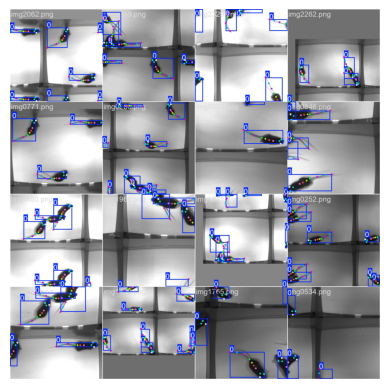

Validation Images


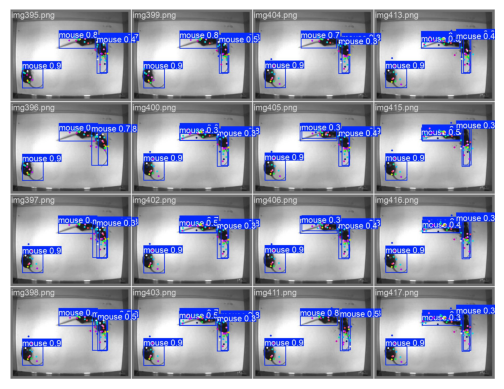

In [7]:
from PIL import Image
import matplotlib.pyplot as plt

print("Training Images")
image = Image.open(Path("/content/runs/pose/train/train_batch1.jpg"))
plt.imshow(image)
plt.axis('off')
plt.show()

print("Validation Images")
image = Image.open(Path("/content/runs/pose/train/val_batch1_pred.jpg"))
plt.imshow(image)
plt.axis('off')
plt.show()

## Test the Model

In [8]:
image_paths=list(Path("/content/dataset/trimice-test/trimice-dlc-2021-06-22/labeled-data/videocompressed0").glob("*"))
results = model(image_paths)


0: 480x640 3 mouses, 6.6ms
1: 480x640 2 mouses, 6.6ms
2: 480x640 3 mouses, 6.6ms
3: 480x640 3 mouses, 6.6ms
4: 480x640 3 mouses, 6.6ms
5: 480x640 4 mouses, 6.6ms
6: 480x640 4 mouses, 6.6ms
Speed: 1.4ms preprocess, 6.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


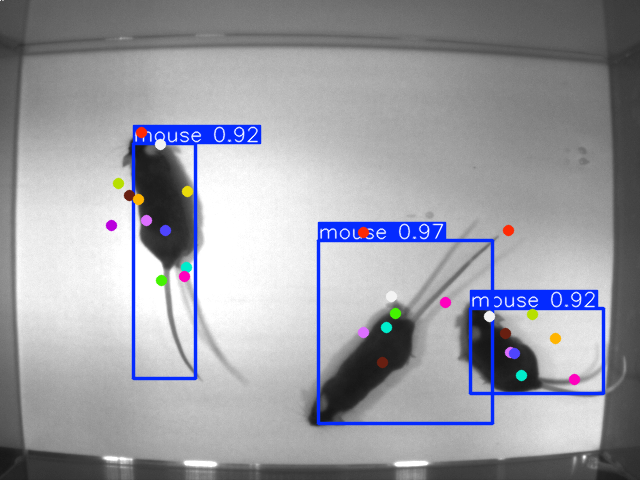

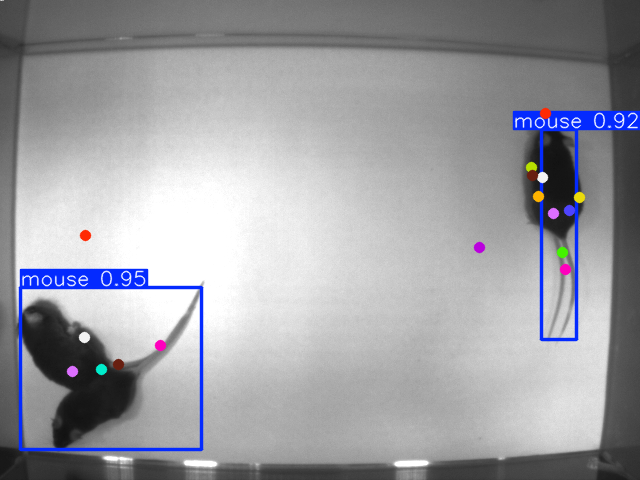

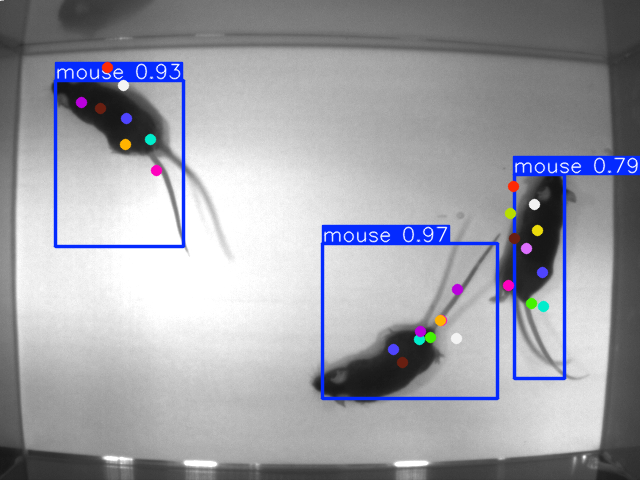

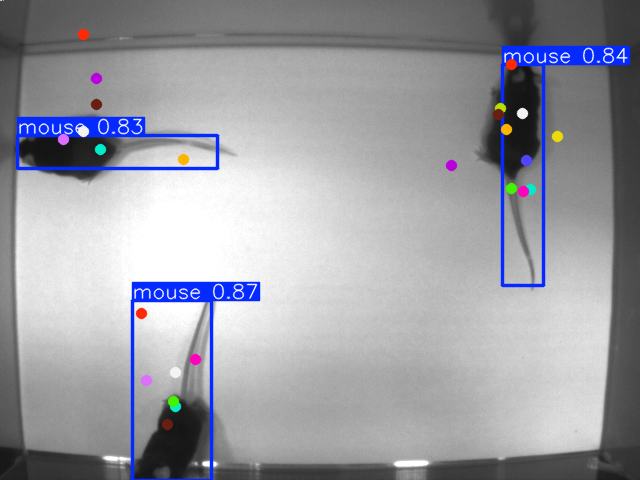

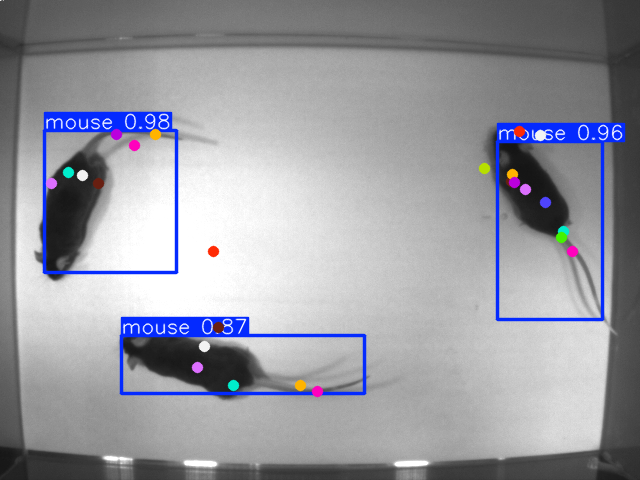

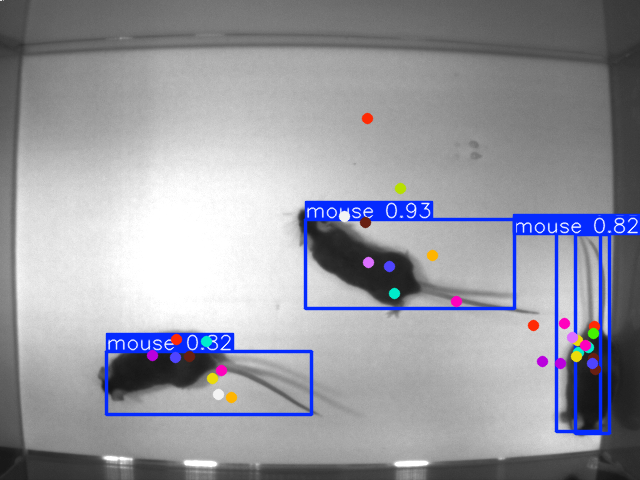

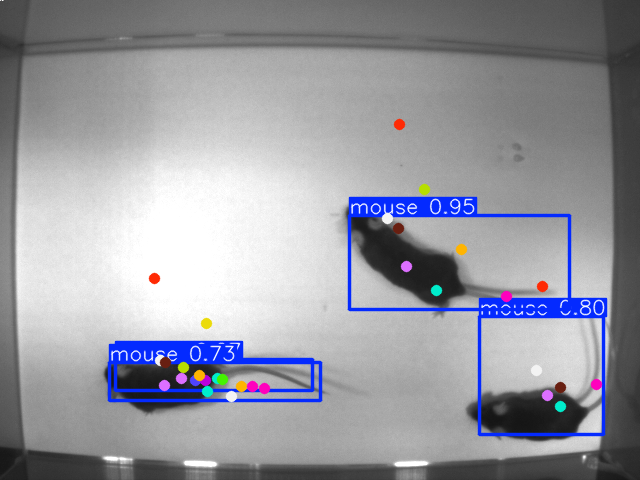

In [9]:
for r in results:
  r.show()